# Experimental results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.interpolate import make_smoothing_spline
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())

In [ ]:
df = pd.read_csv('v7.csv')
df = df.drop(columns=['Unnamed: 0', 'in_agent_ratio', 'out_agent_ratio', 'blnc'])

In [ ]:
df

,lnc,gnc,places,transitions,places_communication
0,1.000000,0.000000,1,1,0
1,1.000000,0.000000,1,1,0
2,1.000000,0.000000,1,1,0
3,1.000000,0.000000,1,1,0
4,1.000000,0.000000,1,1,0
...,...,...,...,...,...
109995,0.450658,0.452055,10,10,10
109996,0.452700,0.453552,10,10,10
109997,0.428176,0.430636,10,10,10
109998,0.413467,0.418605,10,10,10


In [ ]:
df_tr_3 = df[(df['transitions'] == 3) & (df['places'] == 5)]
df_tr_3_gr = df_tr_3.groupby(by=['places_communication']).agg(
    lnc_avg=pd.NamedAgg(column="lnc", aggfunc=np.mean),
    gnc_avg=pd.NamedAgg(column="gnc", aggfunc=np.mean),
    lnc_var=pd.NamedAgg(column="lnc", aggfunc=np.var),
    gnc_var=pd.NamedAgg(column="gnc", aggfunc=np.var),
    ).reset_index()

/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function mean at 0x7913c0a31440> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function var at 0x7913c0a316c0> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function mean at 0x7913c0a31440> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" 

In [ ]:
df_tr_3_gr

,places_communication,lnc_avg,gnc_avg,lnc_var,gnc_var
0,1,0.838611,0.736879,0.006226,0.014016
1,2,0.733111,0.633932,0.010961,0.011151
2,3,0.636389,0.557030,0.011248,0.007033
3,4,0.573750,0.520416,0.009099,0.005673
4,5,0.536056,0.487731,0.006331,0.003278
5,6,0.491056,0.462682,0.005938,0.002717
6,7,0.487944,0.455550,0.006174,0.002411
7,8,0.464194,0.438555,0.004075,0.001367
8,9,0.449194,0.436555,0.003825,0.001967
9,10,0.443611,0.430403,0.002050,0.000828


In [ ]:
from typing import Optional
def plot_with_error_bands(x: np.ndarray, y: np.ndarray, yerr: np.ndarray,
                          xlabel: str, ylabel: str,
                          title: str,
                          curve_label: Optional[str] = None,
                          error_band_label: Optional[str] = None,
                          color: Optional[str] = None, ecolor: Optional[str] = None,
                          linewidth: float = 1.0,
                          style: Optional[str] = 'default',
                          capsize: float = 3.0,
                          alpha: float = 0.2,
                          show: bool = False
                          ):
    """
    note:
        - example values for color and ecolor:
            color='tab:blue', ecolor='tab:blue'
        - capsize is the length of the horizontal line for the error bar. Larger number makes it longer horizontally.
        - alpha value create than 0.2 make the error bands color for filling it too dark. Really consider not changing.
        - sample values for curves and error_band labels:
            curve_label: str = 'mean with error bars',
            error_band_label: str = 'error band',
    refs:
        - for making the seaborn and matplot lib look the same see: https://stackoverflow.com/questions/54522709/my-seaborn-and-matplotlib-plots-look-the-same
    """
    if style == 'default':
        # use the standard matplotlib
        plt.style.use("default")
    elif style == 'seaborn' or style == 'sns':
        # looks idential to seaborn
        import seaborn as sns
        sns.set()
    elif style == 'seaborn-darkgrid':
        # uses the default colours of matplot but with blue background of seaborn
        plt.style.use("seaborn-darkgrid")
    elif style == 'ggplot':
        # other alternative to something that looks like seaborn
        plt.style.use('ggplot')

    # ax = plt.gca()
    # fig = plt.gcf(
    # fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, tight_layout=True)
    # plt.errorbar(x=x, y=y, yerr=yerr, color=color, ecolor=ecolor,
                #  capsize=capsize, linewidth=linewidth, label=curve_label)
    plt.plot(x, y, label=title)
    # print(curve_label)
    plt.fill_between(x=x, y1=y - yerr, y2=y + yerr, alpha=alpha, label=error_band_label)
    plt.grid(True)
    # if curve_label or error_band_label:
    #     plt.legend()
    # plt.title(title)
    # plt.xlabel(xlabel)
    # plt.ylabel(ylabel)
    plt.ylim((.4, .9))

    if show:
        plt.show()

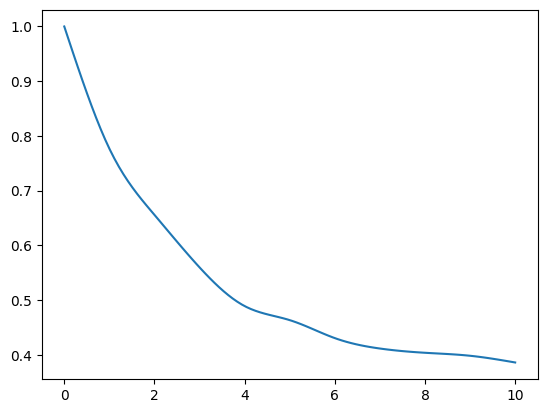

In [ ]:
t = np.linspace(0, 10, 100)
s = make_smoothing_spline(x, y)
plt.plot(t, s(t))

In [ ]:
x = df_tr_3_gr['places_communication']
y = df_tr_3_gr['gnc_avg']

/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function mean at 0x7913c0a31440> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function var at 0x7913c0a316c0> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function mean at 0x7913c0a31440> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" 

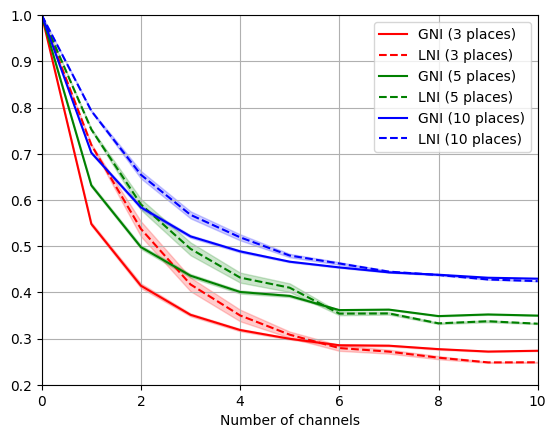

In [ ]:
for p, c in zip([3, 5, 10], ['r', 'g', 'b', 'm']):
    df_tr_3 = df[(df['transitions'] == 10) & (df['places'] == p)]
    df_tr_3_gr = df_tr_3.groupby(by=['places_communication']).agg(
        lnc_avg=pd.NamedAgg(column="lnc", aggfunc=np.mean),
        gnc_avg=pd.NamedAgg(column="gnc", aggfunc=np.mean),
        lnc_var=pd.NamedAgg(column="lnc", aggfunc=np.var),
        gnc_var=pd.NamedAgg(column="gnc", aggfunc=np.var),
        ).reset_index()

    x = df_tr_3_gr['places_communication']
    y = df_tr_3_gr['gnc_avg']
    s = make_smoothing_spline(x, y)
    t = np.linspace(0, 10, 100)
    yerr = df_tr_3_gr['gnc_var']

    # plt.plot(t, s(t), label='GNI ({} places)'.format(p), c=c)
    plt.plot(x, y, label='GNI ({} places)'.format(p), c=c)

    s1 = make_smoothing_spline(x, y - yerr)(t)
    s2 = make_smoothing_spline(x, y + yerr)(t)
    # plt.fill_between(x=t, y1=s1, y2=s2, alpha=0.2, color=c)
    plt.fill_between(x=x, y1=y-yerr, y2=y+yerr, alpha=0.2, color=c)

    x = df_tr_3_gr['places_communication']
    y = df_tr_3_gr['lnc_avg']
    s = make_smoothing_spline(x, y)
    t = np.linspace(0, 10, 100)
    yerr = df_tr_3_gr['lnc_var']

    # plt.plot(t, s(t), label='LNI ({} places)'.format(p), ls='--', c=c)
    plt.plot(x, y, label='LNI ({} places)'.format(p), ls='--', c=c)
    s1 = make_smoothing_spline(x, y - yerr)(t)
    s2 = make_smoothing_spline(x, y + yerr)(t)
    # plt.fill_between(x=t, y1=s1, y2=s2, alpha=0.2, color=c)
    plt.fill_between(x=x, y1=y-yerr, y2=y+yerr, alpha=0.2, color=c)

plt.grid(True)
plt.xlim((0, 10))
plt.ylim((.2, 1.))
plt.legend(loc='best')
# plt.title('Experiment evaluation (5 transitions)')
plt.xlabel('Number of channels')
plt.savefig('channels.png')
# plt.ylabel('Characteristic value')

In [ ]:
x, y

(Series([], Name: places_communication, dtype: int64),
 Series([], Name: gnc_avg, dtype: float64))

/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function mean at 0x7913c0a31440> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function var at 0x7913c0a316c0> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function mean at 0x7913c0a31440> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" 

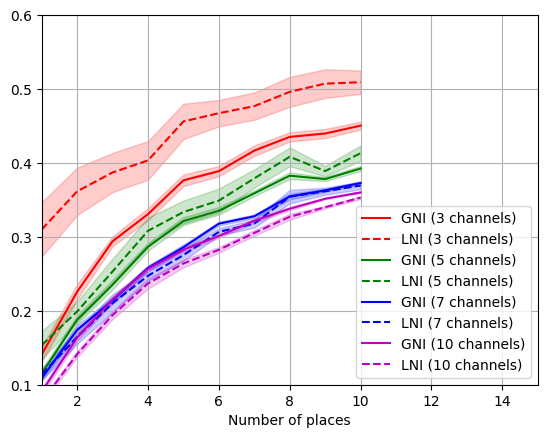

In [ ]:
for p, c in zip([3, 5, 7, 10], ['r', 'g', 'b', 'm']):
    df_tr_3 = df[(df['transitions'] == 3) & (df['places_communication'] == p)]
    df_tr_3_gr = df_tr_3.groupby(by=['places']).agg(
        lnc_avg=pd.NamedAgg(column="lnc", aggfunc=np.mean),
        gnc_avg=pd.NamedAgg(column="gnc", aggfunc=np.mean),
        lnc_var=pd.NamedAgg(column="lnc", aggfunc=np.var),
        gnc_var=pd.NamedAgg(column="gnc", aggfunc=np.var),
        ).reset_index()

    x = df_tr_3_gr['places']
    y = df_tr_3_gr['gnc_avg']
    s = make_smoothing_spline(x, y)
    t = np.linspace(1, 15, 100)
    yerr = df_tr_3_gr['gnc_var']

    # plt.plot(t, s(t), label='GNI ({} channels)'.format(p), c=c)
    plt.plot(x, y, label='GNI ({} channels)'.format(p), c=c)
    s1 = make_smoothing_spline(x, y - yerr)(t)
    s2 = make_smoothing_spline(x, y + yerr)(t)
    plt.fill_between(x=x, y1=y-yerr, y2=y+yerr, alpha=0.2, color=c)

    x = df_tr_3_gr['places']
    y = df_tr_3_gr['lnc_avg']
    s = make_smoothing_spline(x, y)
    t = np.linspace(1, 15, 100)
    yerr = df_tr_3_gr['lnc_var']

    # plt.plot(t, s(t), label='LNI ({} channels)'.format(p), ls='--', c=c)
    plt.plot(x, y, label='LNI ({} channels)'.format(p), ls='--', c=c)
    s1 = make_smoothing_spline(x, y - yerr)(t)
    s2 = make_smoothing_spline(x, y + yerr)(t)
    # plt.fill_between(x=t, y1=s1, y2=s2, alpha=0.2, color=c)
    plt.fill_between(x=x, y1=y-yerr, y2=y+yerr, alpha=0.2, color=c)

plt.grid(True)
plt.xlim((1, 15))
plt.ylim((.1, .6))
plt.legend(loc='best')
# plt.title('Experiment evaluation (5 transitions)')
plt.xlabel('Number of places')
plt.savefig('places.png')

Text(0, 0.5, 'Characteristic value')

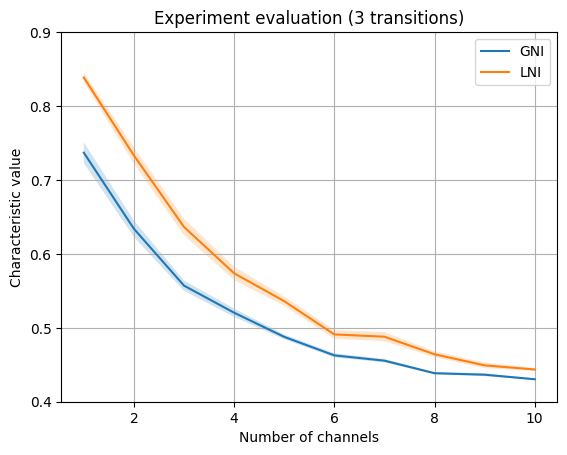

In [ ]:
plot_with_error_bands(df_tr_3_gr['places_communication'], df_tr_3_gr['gnc_avg'], df_tr_3_gr['gnc_var'],
                      'places_communication', 'gnc', 'GNI',)
plot_with_error_bands(df_tr_3_gr['places_communication'], df_tr_3_gr['lnc_avg'], df_tr_3_gr['lnc_var'],
                      'places_communication', 'lnc', 'LNI')
plt.legend(loc='best')
plt.title('Experiment evaluation (3 transitions)')
plt.xlabel('Number of channels')
plt.ylabel('Characteristic value')

# Source code

In [ ]:
!pip install -q pm4py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.8 MB/s eta 0:00:00


In [ ]:
import pm4py as pm
import numpy as np
import networkx as nx
from pm4py.objects.petri_net.obj import PetriNet
from pm4py.objects.petri_net.utils.petri_utils import add_place, add_transition, add_arc_from_to
from pm4py.objects.petri_net.utils.petri_utils import remove_unconnected_components
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [ ]:
def make_petri_net(matr, trans_labels, trans_names, places):
    assert len(matr) == len(places)
    assert len(matr[0]) == len(trans_names)
    assert len(trans_names) == len(trans_labels)
    petri_net = PetriNet()
    transitions_dict = dict()
    places_dict = dict()
    for t in zip(trans_names, trans_labels):
        transitions_dict[t[0]] = add_transition(petri_net, name=t[0], label=t[1])

    for p in places:
        places_dict[p] = add_place(petri_net, name=p)

    for i in range(len(matr)):
        for j in range(len(matr[i])):
            if matr[i][j] == 1:
                add_arc_from_to(places_dict[places[i]], transitions_dict[trans_names[j]], petri_net)
            elif matr[i][j] == -1:
                add_arc_from_to(transitions_dict[trans_names[j]], places_dict[places[i]], petri_net)
    return petri_net

def make_transition_matrix(pn):
    transition_matrix = {}
    for p in pn.places:
        for in_arc in p.in_arcs:
            for out_arc in p.out_arcs:
                if in_arc.source.label is not None and out_arc.target.label is not None:
                    transition_matrix[in_arc.source.label] = transition_matrix.get(
                        in_arc.source.label, set()
                    ).union(set([out_arc.target.label]))

#                     transition_matrix[out_arc.target.label] = transition_matrix.get(
#                         out_arc.target.label, set()
#                     ).union(set([in_arc.source.label]))
    return transition_matrix

def make_transition_matrix_v2(petri_net):
    res = dict()

    def foo(state, t, visited):
        if type(state) is PetriNet.Transition and state.label is not None:
            res[t].add(state.label)
        else:
            for a in state.out_arcs:
                if a.target.name not in visited:
                    foo(a.target, t, visited + [a.target.name])

    for t in filter(lambda t: t.label is not None, petri_net.transitions):
        res[t.label] = set()
        for a in t.out_arcs:
            foo(a.target, t.label, [t.name, a.target.name])

    return res

def gnc(tm):
    n_d = 0
    n_a = 0
    for k, v in tm.items():
        n_a += len(v)
        n_d += len(list(filter(lambda x: x[0] != k[0], v)))
    if n_a == 0:
        return 0
    return 1 - n_d / n_a

# def sc2(tm):
#     numer = 0
#     denom = len(tm)
#     for k, v in tm.items():
#         if len(list(filter(lambda x: x[0] != k[0], v))) == 0:
#             numer += 1
#     return numer / denom

def lnc(tm):
    res = 0
    for k, v in tm.items():
        n_a = len(v)
        n_d = len(list(filter(lambda x: x[0] != k[0], v)))
        if n_a != 0:
            res += n_d / n_a
    return 1 - res / len(tm)

def blnc(tm):
    res = 0
    agents = set(map(lambda x: x[0], tm.keys()))
    for a in agents:
        agent_res = 0
        for k, v in filter(lambda x: x[0][0] == a, tm.items()):
            # print(a, k)
            n_a = len(v)
            n_d = len(list(filter(lambda x: x[0] != k[0], v)))
            if n_a != 0:
                agent_res += n_d / n_a
        # print(agent_res / len(list(filter(lambda x: x[0][0] == a, tm.items()))))
        res += agent_res / len(list(filter(lambda x: x[0][0] == a, tm.items())))
    return 1 - res / len(agents)

#
def create_networkx_directed_graph(net, weight=None):
    """
    Create a NetworkX directed graph from a Petri net

    Parameters
    --------------
    net
        Petri net

    Returns
    --------------
    graph
        NetworkX digraph
    inv_dictionary
        Correspondence between NetworkX nodes and Petri net entities
    """
    import networkx as nx

    graph = nx.DiGraph()
    dictionary = {}
    inv_dictionary = {}
    for place in net.places:
        value = len(dictionary)
        dictionary[place] = value
        inv_dictionary[value] = place
        graph.add_node(dictionary[place])
    for transition in net.transitions:
        value = len(dictionary)
        dictionary[transition] = value
        inv_dictionary[value] = transition
        graph.add_node(dictionary[transition])
    for arc in net.arcs:
        source = dictionary[arc.source]
        target = dictionary[arc.target]
        graph.add_edge(source, target)
        if weight is not None:
            if type(inv_dictionary[source]) is PetriNet.Transition:
                graph.edges[source, target]["weight"] = weight[inv_dictionary[source]]
            else:
                graph.edges[source, target]["weight"] = weight[inv_dictionary[target]]
    return graph, inv_dictionary

def make_transitions_dict(petri_net):
    d = dict()
    for t in petri_net.transitions:
        d[t.label] = t
    return d

# Random genration

In [ ]:
def _generate_petri_net_model(
        distr_in_agent_ratio,
        distr_out_agent_ratio,
        agents_num,
        agents_trans_num = [3, 3],
        agents_places_num = [3, 3],
        interaction_places_num = 2,
        none_trans_num = 0,
        ):

    total_trans = sum(agents_trans_num) + none_trans_num
    total_places = sum(agents_places_num) + interaction_places_num

    def distr_in_agent():
        u = np.random.uniform()
        if u >= distr_in_agent_ratio:
            return 0
        else:
            return np.random.choice([-1, 1])

    def distr_out_agent():
        u = np.random.uniform()
        if u >= distr_out_agent_ratio:
            return 0
        else:
            return 1

    res = np.zeros(shape=(total_places, total_trans), dtype=int)
    agent_offset_row = 0
    agent_offset_col = 0
    for i in range(agents_num):
        for row in range(agents_places_num[i]):
            for col in range(agents_trans_num[i]):
                res[row + agent_offset_row][col + agent_offset_col] = distr_in_agent()
        agent_offset_row += agents_places_num[i]
        agent_offset_col += agents_trans_num[i]

    for i in range(none_trans_num):
        pass

    # добавить логику учета, что каналы принимают фиксировано (случайно определятеся)
    # от одного агента и отдают другому
    for row in range(interaction_places_num):
        agent = np.random.choice([1, -1])

        for col in range(agents_trans_num[0]):
            res[row + agent_offset_row][col] = agent * distr_out_agent()
            res[row + agent_offset_row][agents_trans_num[0] + col] = -1 * agent * distr_out_agent()

    trans_labels = []
    offset = 0
    for agent_num, agent in enumerate(agents_trans_num):
        for i in range(agent):
            trans_labels.append(f'{agent_num}_{i}')
        offset = agent
    for _ in range(none_trans_num):
        trans_labels.append(None)

    trans_names = [f't_{i}' for i in range(total_trans)]
    places = [f'p_{i}' for i in range(total_places)]
#     return remove_unconnected_components(make_petri_net(res, trans_labels, trans_names, places))
    return make_petri_net(res, trans_labels, trans_names, places)

def generate_petri_net_model(**d):
    # i = 0
    # cycles = [1]
    # while len(list(cycles)) != 0 and i < max_iters:
    #     petri_net = _generate_petri_net_model(**d)
    #     graph, inv_dictionary = create_networkx_directed_graph(petri_net)
    #     cycles = nx.simple_cycles(graph)
    #     i += 1

    # if i == max_iters:
    #     raise ValueError('No petri net is acyclic', i)
    # print('Took {} iterations'.format(i))
    # return remove_unconnected_components(petri_net)
    petri_net = _generate_petri_net_model(**d)
    return petri_net

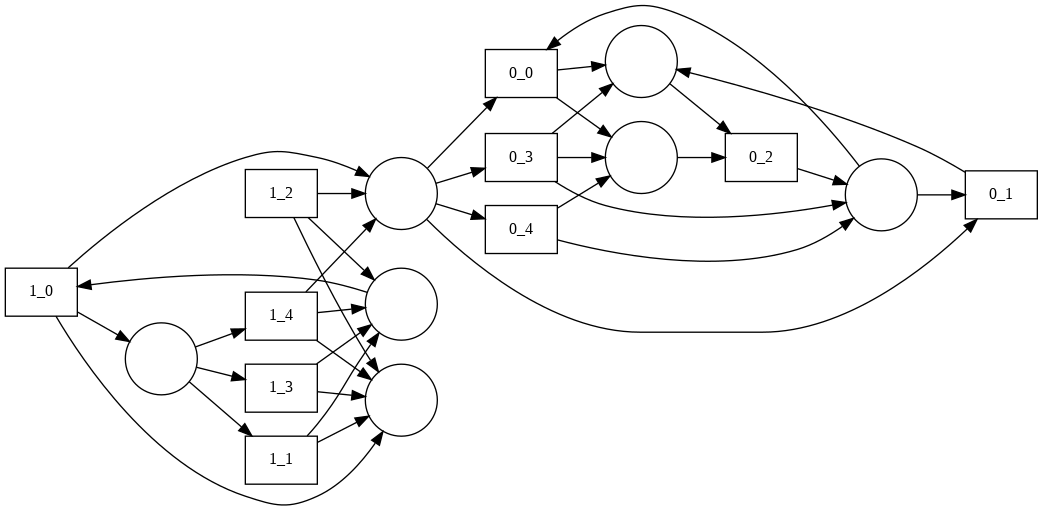

In [ ]:
petri_net = generate_petri_net_model(
    distr_in_agent_ratio=.8,
    distr_out_agent_ratio=.8,
    agents_num = 2,
    agents_trans_num = [5, 5],
    agents_places_num = [3, 3],
    interaction_places_num = 1,
    none_trans_num = 0,
)
pm.view_petri_net(petri_net)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
tm

{'0_0': {'0_1', '0_2', '0_3', '0_4', '1_0', '1_1', '1_4'},
 '0_1': {'0_2', '0_3', '0_4', '1_0', '1_1', '1_4'},
 '0_2': {'0_1', '1_0', '1_1', '1_4'},
 '0_3': {'0_1', '1_0', '1_1', '1_4'},
 '0_4': {'0_0', '0_2', '0_3'},
 '1_0': set(),
 '1_1': set(),
 '1_2': {'1_0', '1_1', '1_3'},
 '1_3': set(),
 '1_4': {'1_0', '1_1', '1_2', '1_3'}}

In [ ]:

tm = make_transition_matrix_v2(petri_net)
print(tm)
print('lnc = ', lnc(tm))
print('gnc = ', gnc(tm))
print('blnc = ', blnc(tm))

{'0_0': {'1_1', '0_3', '0_4', '0_2', '1_0', '1_2', '0_1'}, '0_1': {'1_1', '0_3', '0_0', '0_4', '0_2', '1_0', '1_2'}, '0_3': {'1_1', '0_0', '0_4', '0_2', '1_0', '1_2', '0_1'}, '0_2': {'1_1', '0_3', '0_0', '0_4', '1_0', '1_2'}, '0_4': {'1_1', '0_3', '0_0', '0_2', '1_0', '1_2', '0_1'}, '1_0': {'0_3'}, '1_1': {'0_3', '0_0', '0_2', '1_0', '1_2', '0_1'}, '1_2': {'1_1', '0_3', '1_0'}}
lnc =  0.4732142857142858
gnc =  0.5227272727272727
blnc =  0.4452380952380953


In [ ]:
from tqdm import tqdm
import pandas as pd

In [ ]:
num_of_eval = 100
p_range = range(1, 11)
t_range = range(1, 11)
# t_range = [5]
a_range = range(0, 11)
agent_range = 0.5 #np.arange(0.5, 1.01, 0.05)
cols = ['lnc', 'blnc', 'gnc', 'places', 'transitions', 'in_agent_ratio', 'out_agent_ratio', 'places_communication']
df = pd.DataFrame(columns=cols)


# for i_r in tqdm(agent_range):
    # for o_r in agent_range:
i_r = 0.8
o_r = 0.8

for a in tqdm(a_range):
    for t in t_range:
        for p in p_range:
            for i in range(num_of_eval):
                petri_net = generate_petri_net_model(
                    distr_in_agent_ratio=i_r,
                    distr_out_agent_ratio=o_r,
                    agents_num = 2,
                    agents_trans_num = [t, t],
                    agents_places_num = [p, p],
                    interaction_places_num = a,
                    none_trans_num = 0,
                )
                tm = make_transition_matrix_v2(petri_net)
                _lnc = lnc(tm)
                _gnc = gnc(tm)
                _blnc = blnc(tm)
                cur_row = pd.DataFrame.from_dict([dict(zip(cols, [_lnc, _blnc, _gnc, p, t, i_r, o_r, a]))])
                df = pd.concat([df, cur_row])


  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return fn(*args, **kwargs)
100%|██████████| 11/11 [13:45<00:00, 75.05s/it]


In [ ]:
df.to_csv('v7.csv')

In [ ]:
i_r, o_r

(0.1, 0.8)

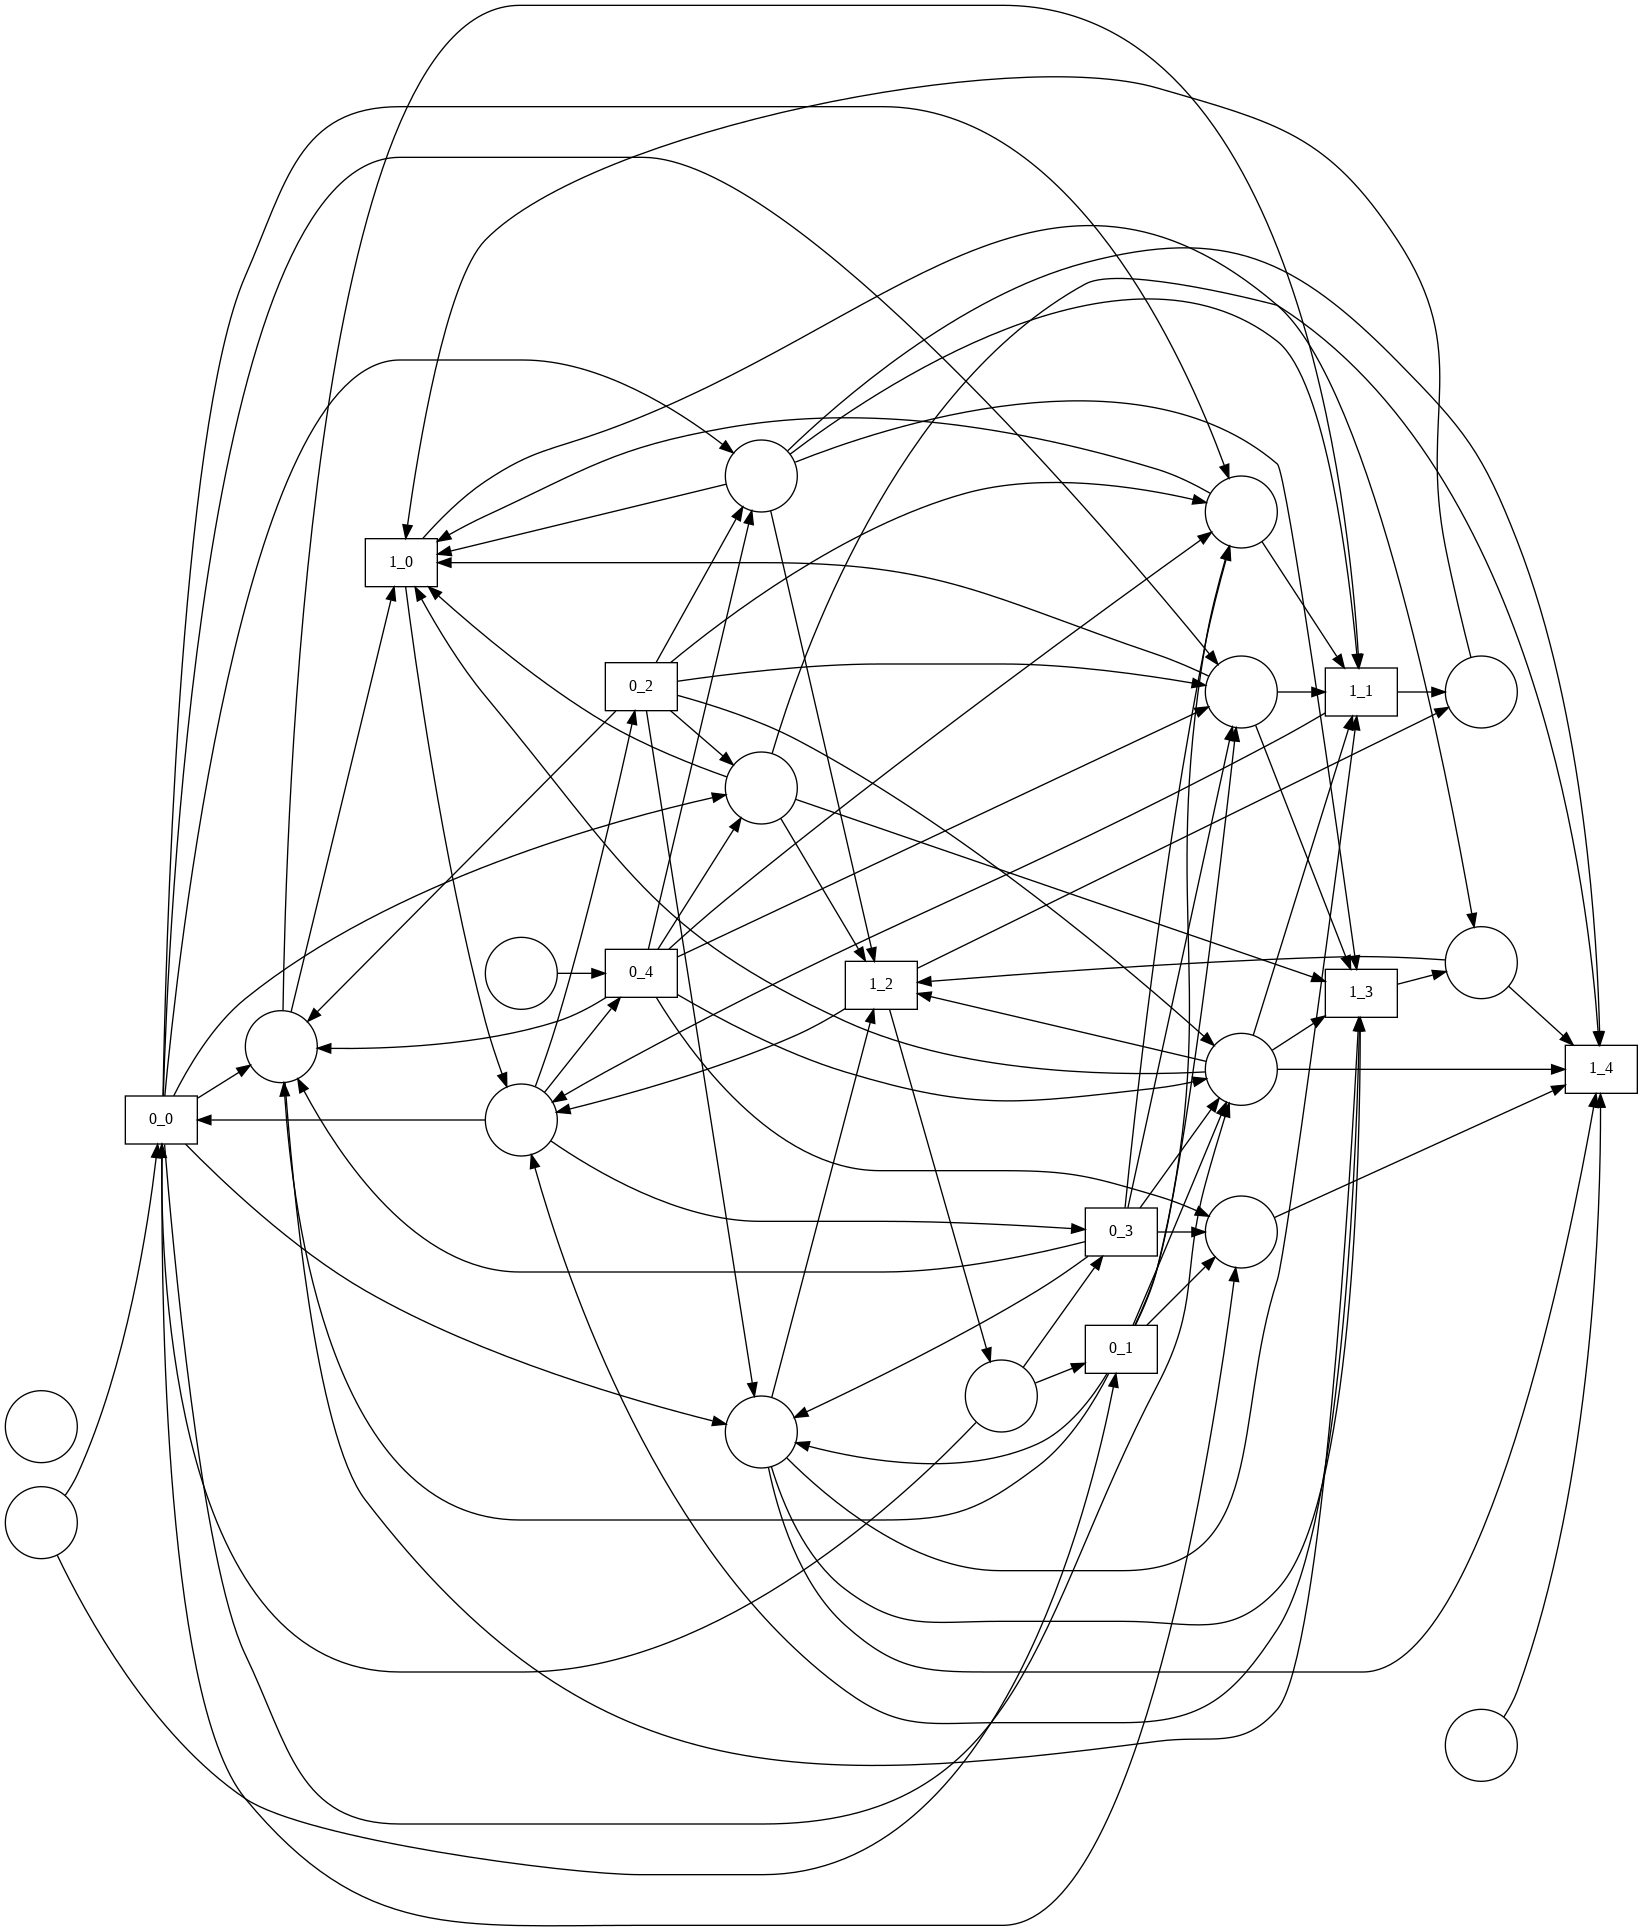

{'0_0': {'1_0', '1_1', '1_2', '1_3', '1_4'},
 '0_1': {'1_0', '1_1', '1_2', '1_3', '1_4'},
 '0_4': {'1_0', '1_1', '1_2', '1_3', '1_4'},
 '0_3': {'1_0', '1_1', '1_2', '1_3', '1_4'},
 '0_2': {'1_0', '1_1', '1_2', '1_3', '1_4'},
 '1_0': {'0_0', '0_2', '0_3', '0_4', '1_2', '1_4'},
 '1_1': {'0_0', '0_2', '0_3', '0_4', '1_0'},
 '1_2': {'0_0', '0_1', '0_2', '0_3', '0_4', '1_0'},
 '1_3': {'0_0', '0_2', '0_3', '0_4', '1_2', '1_4'},
 '1_4': set()}

In [ ]:
petri_net = generate_petri_net_model(
                    distr_in_agent_ratio=0.5,
                    distr_out_agent_ratio=.8,
                    agents_num = 2,
                    agents_trans_num = [5, 5],
                    agents_places_num = [3, 3],
                    interaction_places_num = a,
                    none_trans_num = 0,
                )
tm = make_transition_matrix_v2(petri_net)
pm.view_petri_net(petri_net)
tm

In [ ]:
tm

{'0_0': {'0_1', '0_2', '0_3', '0_4', '1_0', '1_1', '1_2', '1_3', '1_4'},
 '0_2': {'0_0', '0_1', '0_3', '0_4', '1_0', '1_1', '1_2', '1_3', '1_4'},
 '0_3': {'0_0', '0_1', '0_2', '0_4', '1_0', '1_1', '1_2', '1_4'},
 '0_1': {'0_0', '0_2', '0_3', '0_4', '1_0', '1_1', '1_2', '1_3', '1_4'},
 '0_4': {'0_0', '0_1', '0_2', '0_3', '1_0', '1_1', '1_2', '1_3', '1_4'},
 '1_0': {'0_0', '0_1', '0_2', '0_3', '0_4', '1_1', '1_2', '1_3', '1_4'},
 '1_1': {'0_0', '0_1', '0_2', '0_3', '0_4', '1_0', '1_2', '1_3', '1_4'},
 '1_2': {'0_1', '0_2', '0_3', '0_4', '1_0', '1_1', '1_3', '1_4'},
 '1_3': {'0_0', '0_1', '0_2', '0_3', '0_4', '1_0', '1_1', '1_2', '1_4'},
 '1_4': {'0_0', '0_1', '0_2', '0_3', '0_4', '1_0', '1_1', '1_2'}}

places


/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function mean at 0x7e3f9a6393a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function std at 0x7e3f9a6394e0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function mean at 0x7e3f9a6393a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" 

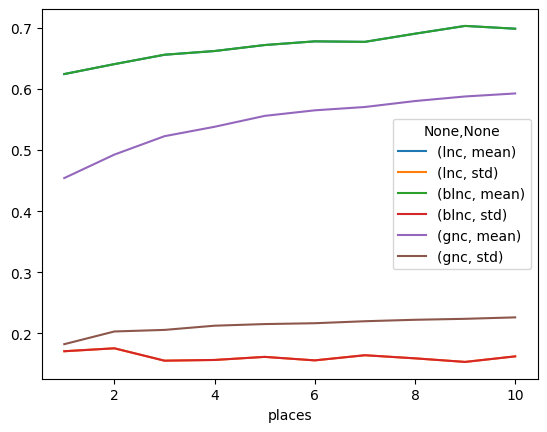

transitions


/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function mean at 0x7e3f9a6393a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function std at 0x7e3f9a6394e0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function mean at 0x7e3f9a6393a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" 

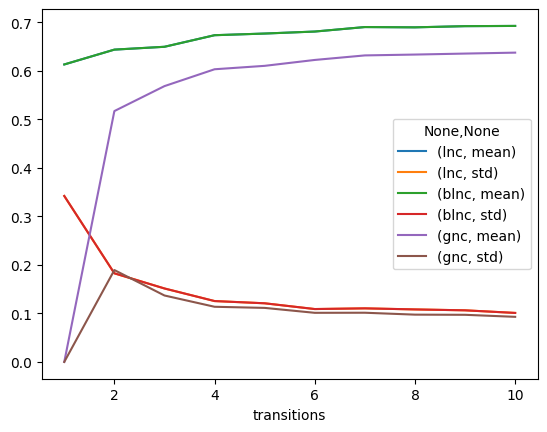

in_agent_ratio


/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function mean at 0x7e3f9a6393a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function std at 0x7e3f9a6394e0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  return fn(*args, **kwargs)


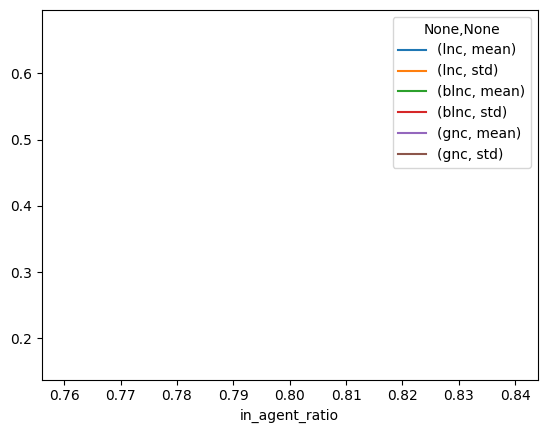

out_agent_ratio


/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function mean at 0x7e3f9a6393a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The provided callable <function std at 0x7e3f9a6394e0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  return fn(*args, **kwargs)


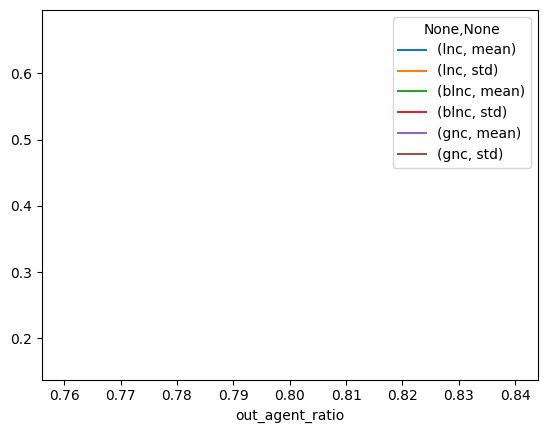

In [ ]:
for grp_col in ['places', 'transitions', 'in_agent_ratio', 'out_agent_ratio']:
    print(grp_col)
    df[[grp_col, 'lnc', 'blnc', 'gnc']].groupby(by=[grp_col]).aggregate([np.mean, np.std]).plot()
    plt.show()

# Пример сети композиции

## Пример для статьи

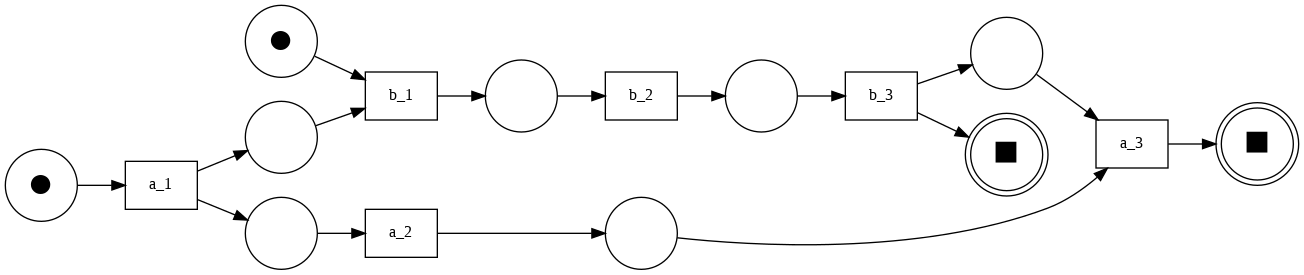

In [ ]:
matr = [
    [1, 0, 0, 0, 0, 0],
   [-1, 1, 0, 0, 0, 0],
    [0,-1, 1, 0, 0, 0],
    [0, 0, -1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0,-1, 1, 0],
    [0, 0, 0, 0,-1, 1],
    [0, 0, 0, 0, 0,-1],
   [-1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0,-1],
]
trans_labels = ['a_1', 'a_2', 'a_3', 'b_1', 'b_2', 'b_3']
trans_names = [f't_{i}' for i in range(6)]
places = [f'p_{i}' for i in range(10)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)
places = sorted(list(petri_net.places), key=lambda x: int(x.name.split('_')[1]))
im = pm.objects.petri_net.obj.Marking([places[0], places[4]])
fm = pm.objects.petri_net.obj.Marking([places[3], places[7]])
pm.view_petri_net(petri_net, im, fm)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'a_1': {'a_2', 'b_1'}, 'b_2': {'b_3'}, 'a_3': set(), 'a_2': {'a_3'}, 'b_1': {'b_2'}, 'b_3': {'a_3'}}
gnc  =  0.6666666666666667
lnc  =  0.75
blnc =  0.75


In [ ]:
log = pm.play_out(petri_net, im, fm, )
df = pm.convert_to_dataframe(log)
df = df[df['case:concept:name'].map(int) < 1]

In [ ]:
for i in df.iterrows():
    print(i[1]['concept:name'])

a_1
a_2
b_1
b_2
b_3
a_3


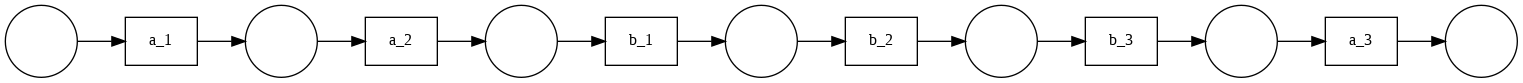

In [ ]:
pn_d, im_d, fm_d = pm.discover_petri_net_inductive(df)
# pm.view_petri_net(pn_d, im_d, fm_d)
pm.view_petri_net(pn_d)

In [ ]:
tm = make_transition_matrix_v2(pn_d)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

print('fitness')
print(pm.conformance.fitness_alignments(df, pn_d, im_d, fm_d,))
print('precision')
print(pm.conformance.precision_token_based_replay(df, pn_d, im_d, fm_d, case_id_key='case:concept:name'))

{'a_1': {'a_2'}, 'b_3': {'a_3'}, 'b_2': {'b_3'}, 'a_2': {'b_1'}, 'b_1': {'b_2'}, 'a_3': set()}
gnc  =  0.6
lnc  =  0.6666666666666667
blnc =  0.6666666666666667
fitness
{'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0}
precision


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

1.0


In [ ]:
pm.

In [ ]:
pm.simplicity_petri_net(pn_d, im_d, fm_d), pm.simplicity_petri_net(petri_net, im, fm)

(1.0, 1.0)

a


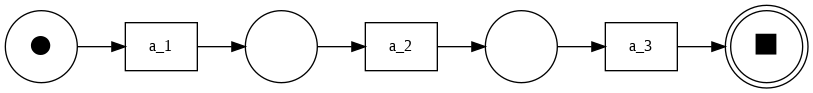

b


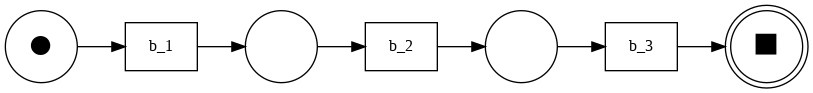

In [ ]:
d = dict()
for l in ['a', 'b']:
    print(l)
    df_l = df[df['concept:name'].str.contains(l)]
    d[l] = pm.discover_petri_net_inductive(df_l)
    pm.view_petri_net(*d[l])


In [ ]:
petri_net_ind = d['a'][0]
places_dict = dict()
transitions_dict = dict()

for p in d['b'][0].places:
    places_dict[p.name] = add_place(petri_net_ind, name=p.name)

for t in d['b'][0].transitions:
    transitions_dict[t.label] = add_transition(petri_net_ind, name=t.name, label=t.label)

for a in list(d['b'][0].arcs):
    if type(a.source) is PetriNet.Place:
        add_arc_from_to(places_dict[a.source.name], transitions_dict[a.target.label], petri_net_ind)
    else:
        add_arc_from_to(transitions_dict[a.source.label], places_dict[a.target.name], petri_net_ind)

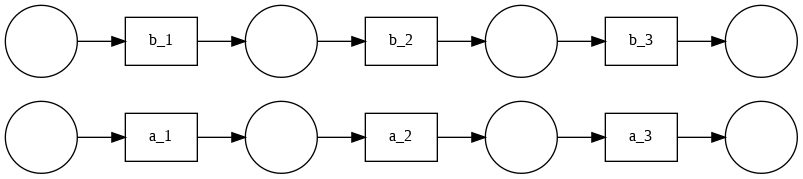

In [ ]:
pm.view_petri_net(petri_net_ind)

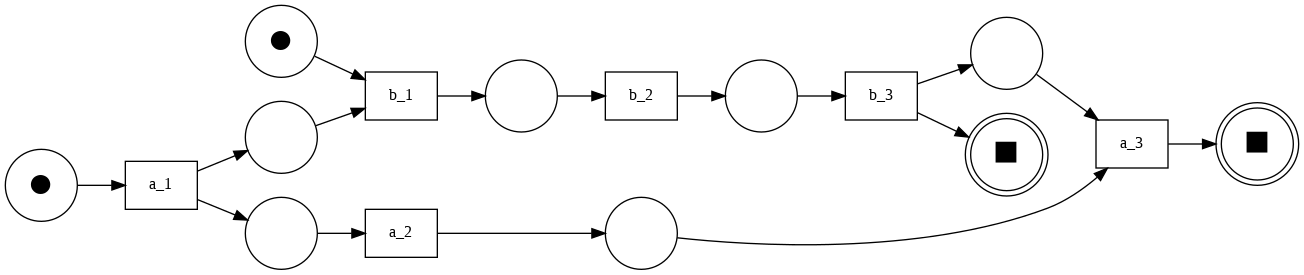

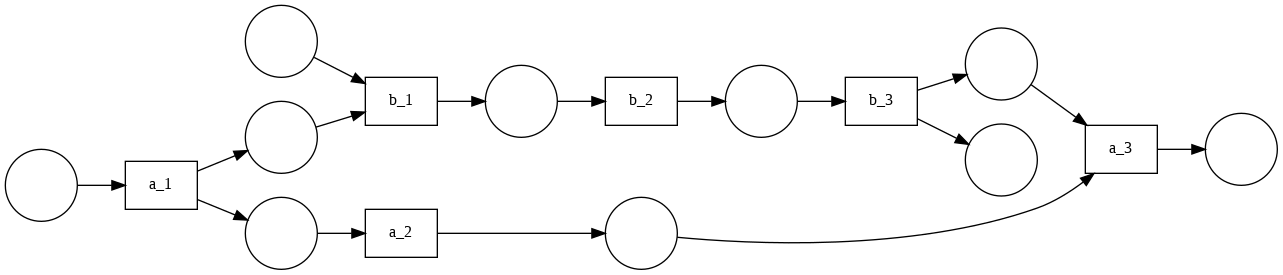

In [ ]:
t_d = make_transitions_dict(petri_net_ind)

c1 = add_place(petri_net_ind, name='c_1')
c2 = add_place(petri_net_ind, name='c_2')

add_arc_from_to(t_d['a_1'], c1, petri_net_ind)
add_arc_from_to(c1, t_d['b_1'], petri_net_ind)

add_arc_from_to(t_d['b_3'], c2, petri_net_ind)
add_arc_from_to(c2, t_d['a_3'], petri_net_ind)

im_ind = pm.objects.petri_net.obj.Marking(list(filter(lambda x: x.name == 'source', petri_net_ind.places)))
fm_ind = pm.objects.petri_net.obj.Marking(list(filter(lambda x: x.name == 'sink', petri_net_ind.places)))

pm.view_petri_net(petri_net_ind, im_ind, fm_ind)
pm.view_petri_net(petri_net_ind)

In [ ]:
cur_petri_net = (petri_net_ind, im_ind, fm_ind)

tm = make_transition_matrix_v2(cur_petri_net[0]
                               )
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

print('fitness')
print(pm.conformance.fitness_alignments(df, *cur_petri_net))
print('precision')
print(pm.conformance.precision_token_based_replay(df, *cur_petri_net))

{'a_1': {'b_1', 'a_2'}, 'a_3': set(), 'b_2': {'b_3'}, 'a_2': {'a_3'}, 'b_1': {'b_2'}, 'b_3': {'a_3'}}
gnc  =  0.6666666666666667
lnc  =  0.75
blnc =  0.75
fitness
{'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0}
precision


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

0.8571428571428572


## Пример для диплома

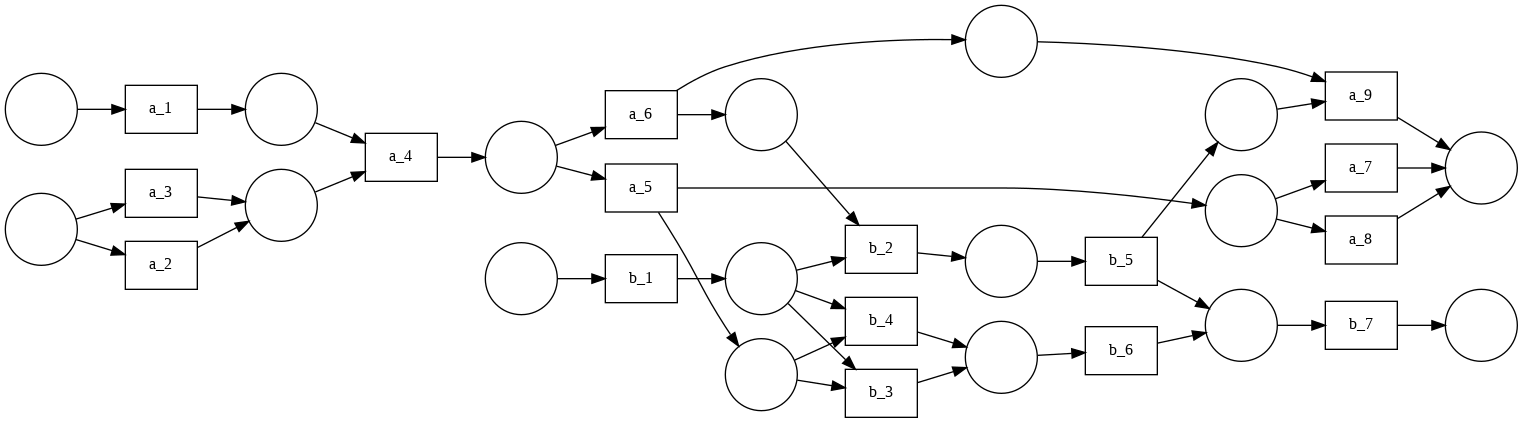

In [ ]:
matr = [
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [-1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0,-1,-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0,-1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0,-1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0,-1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0,-1,-1,-1, 0, 0, 0, 0, 0, 0, 0],
                                #
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1,-1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1],
    #1  2  3  4  5  6  7  8  9 #1  2  3  4  5  6  7
    [0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
    # [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,-1, 0, 0],

]
trans_labels = [f'a_{i}' for i in range(1, 10)] + [f'b_{i}' for i in range(1, 8)]
trans_names = [f't_{i}' for i in range(16)]
places = [f'p_{i}' for i in range(17)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)
pm.view_petri_net(petri_net)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'b_5': {'a_9', 'b_7'}, 'b_6': {'b_7'}, 'a_1': {'a_4'}, 'a_3': {'a_4'}, 'a_2': {'a_4'}, 'a_4': {'a_6', 'a_5'}, 'a_5': {'b_4', 'a_7', 'b_3', 'a_8'}, 'a_6': {'a_9', 'b_2'}, 'a_7': set(), 'a_8': set(), 'a_9': set(), 'b_1': {'b_4', 'b_3', 'b_2'}, 'b_2': {'b_5'}, 'b_7': set(), 'b_4': {'b_6'}, 'b_3': {'b_6'}}
gnc  =  0.8
lnc  =  0.90625
blnc =  0.9087301587301587


In [ ]:
places = sorted(list(petri_net.places), key=lambda x: int(x.name.split('_')[1]))
im = pm.objects.petri_net.obj.Marking(places[:2] + [places[8]])
fm = pm.objects.petri_net.obj.Marking([places[-4], places[7]])

In [ ]:
print('simplicity = ', pm.simplicity_petri_net(petri_net, im, fm))

simplicity =  0.7021276595744681


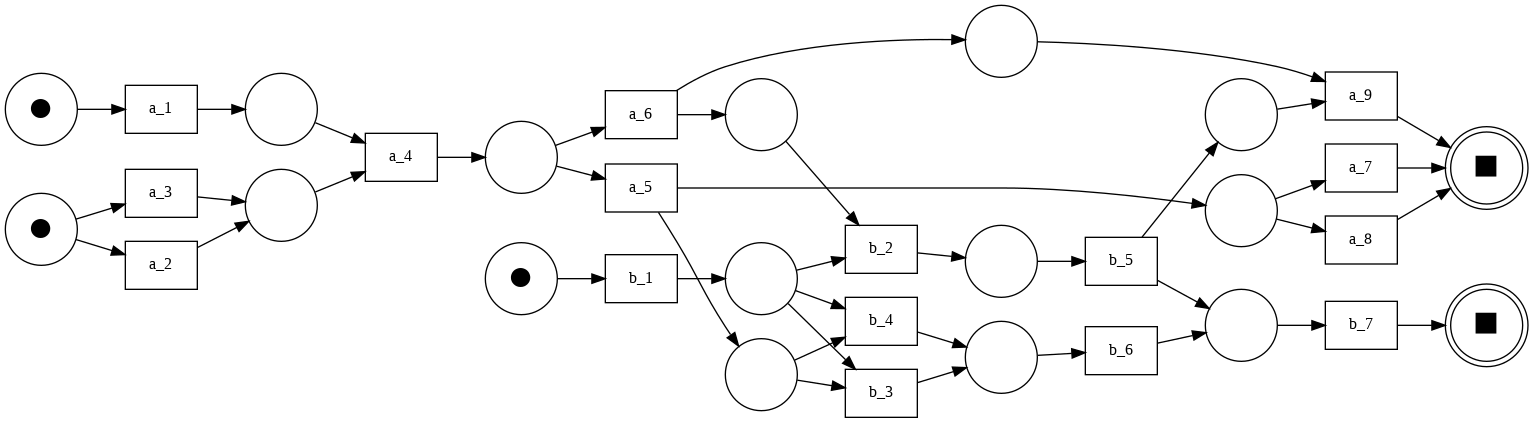

In [ ]:
pm.view_petri_net(petri_net, im, fm)

In [ ]:
log = pm.play_out(petri_net, im, fm, )
df = pm.convert_to_dataframe(log)
df = df[df['case:concept:name'].map(int) < 10]

In [ ]:
df

,concept:name,time:timestamp,case:concept:name
0,a_1,1970-04-26 17:46:40,0
1,b_1,1970-04-26 17:46:41,0
2,a_2,1970-04-26 17:46:42,0
3,a_4,1970-04-26 17:46:43,0
4,a_5,1970-04-26 17:46:44,0
...,...,...,...
85,a_6,1970-04-26 17:48:05,9
86,b_2,1970-04-26 17:48:06,9
87,b_5,1970-04-26 17:48:07,9
88,b_7,1970-04-26 17:48:08,9


In [ ]:
print('fitness')
print(pm.conformance.fitness_alignments(df, petri_net, im, fm))
print('precision')
print(pm.conformance.precision_token_based_replay(df, petri_net, im, fm, case_id_key='case:concept:name'))

fitness


aligning log, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

{'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0}
precision


replaying log with TBR, completed traces ::   0%|          | 0/53 [00:00<?, ?it/s]

0.7764705882352941


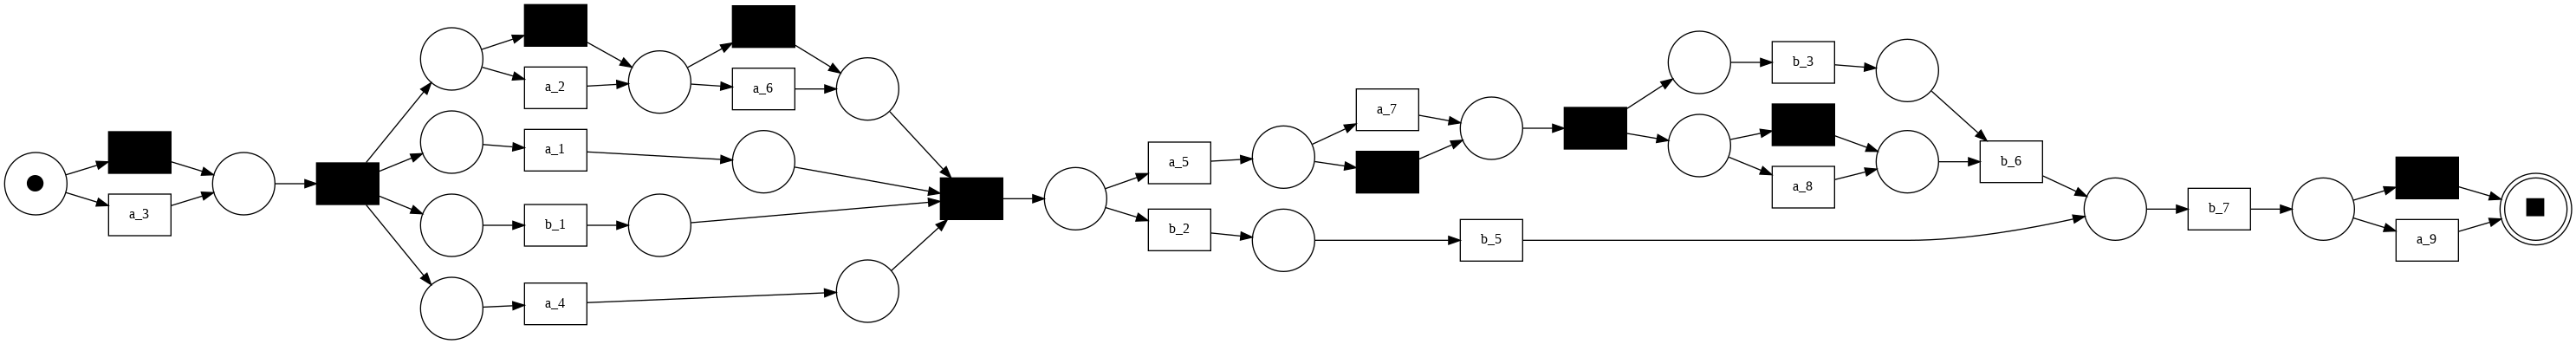

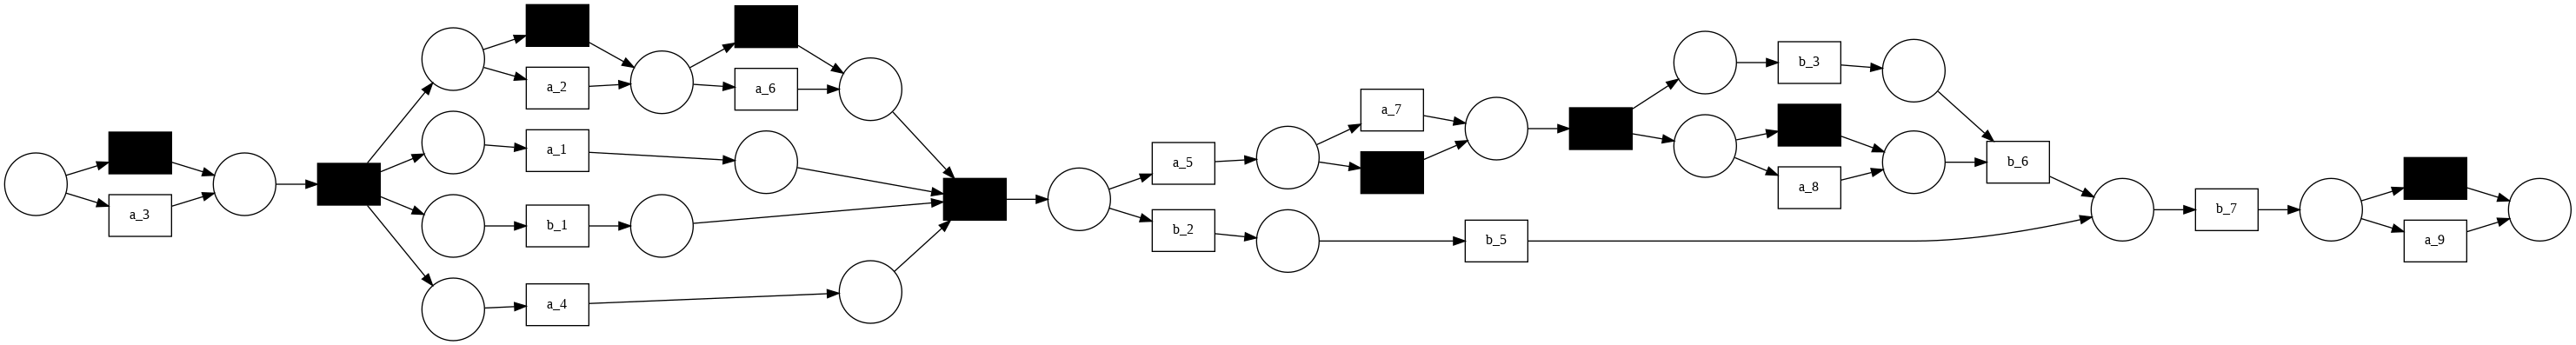

In [ ]:
pn_d, im_d, fm_d = pm.discover_petri_net_inductive(df)
pm.view_petri_net(pn_d, im_d, fm_d)
pm.view_petri_net(pn_d)

In [ ]:
tm = make_transition_matrix_v2(pn_d)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

print('fitness')
print(pm.conformance.fitness_alignments(df, pn_d, im_d, fm_d))
print('precision')
print(pm.conformance.precision_token_based_replay(df, pn_d, im_d, fm_d))

{'a_7': {'b_6', 'b_3', 'a_8'}, 'a_3': {'b_1', 'a_5', 'a_6', 'a_2', 'b_2', 'a_1', 'a_4'}, 'b_1': {'a_5', 'b_2'}, 'b_5': {'b_7'}, 'a_8': {'b_6'}, 'b_6': {'b_7'}, 'a_5': {'b_6', 'a_7', 'b_3', 'a_8'}, 'b_3': {'b_6'}, 'a_1': {'a_5', 'b_2'}, 'a_4': {'a_5', 'b_2'}, 'a_2': {'a_6', 'a_5', 'b_2'}, 'b_2': {'b_5'}, 'a_6': {'a_5', 'b_2'}, 'a_9': set(), 'b_7': {'a_9'}}
gnc  =  0.5806451612903225
lnc  =  0.6142857142857143
blnc =  0.6369047619047619
fitness


aligning log, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

{'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.999969334559951}
precision


replaying log with TBR, completed traces ::   0%|          | 0/53 [00:00<?, ?it/s]

0.534412955465587


a


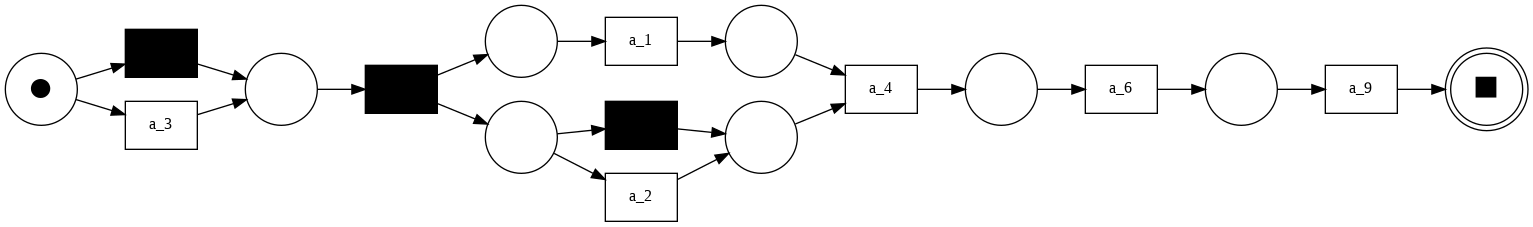

b


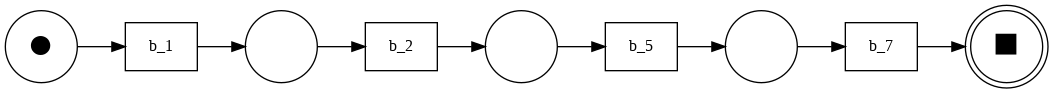

In [ ]:
d = dict()
for l in ['a', 'b']:
    print(l)
    df_l = df[df['concept:name'].str.contains(l)]
    d[l] = pm.discover_petri_net_inductive(df_l)
    pm.view_petri_net(*d[l])


In [ ]:
petri_net_ind = d['a'][0]
places_dict = dict()
transitions_dict = dict()

for p in d['b'][0].places:
    places_dict[p.name] = add_place(petri_net_ind, name=p.name)

for t in d['b'][0].transitions:
    transitions_dict[t.label] = add_transition(petri_net_ind, name=t.name, label=t.label)

for a in list(d['b'][0].arcs):
    if type(a.source) is PetriNet.Place:
        add_arc_from_to(places_dict[a.source.name], transitions_dict[a.target.label], petri_net_ind)
    else:
        add_arc_from_to(transitions_dict[a.source.label], places_dict[a.target.name], petri_net_ind)

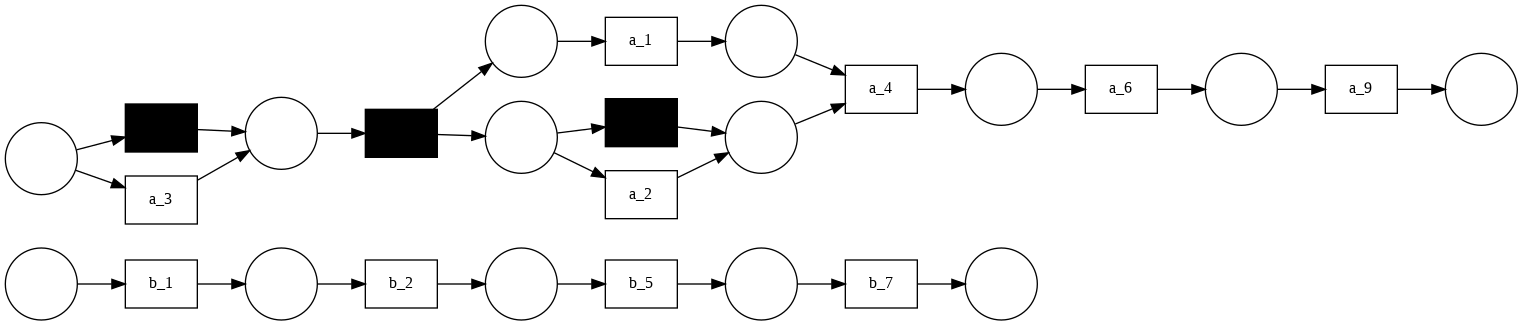

In [ ]:
pm.view_petri_net(petri_net_ind)

In [ ]:
t_d = make_transitions_dict(petri_net_ind)

c1 = add_place(petri_net_ind, name='c_1')
c2 = add_place(petri_net_ind, name='c_2')
c3 = add_place(petri_net_ind, name='c_3')

add_arc_from_to(t_d['a_6'], c1, petri_net_ind)
add_arc_from_to(c1, t_d['b_2'], petri_net_ind)

add_arc_from_to(t_d['a_5'], c2, petri_net_ind)
add_arc_from_to(c2, t_d['b_3'], petri_net_ind)
add_arc_from_to(c2, t_d['b_4'], petri_net_ind)

add_arc_from_to(t_d['b_5'], c3, petri_net_ind)
add_arc_from_to(c3, t_d['a_9'], petri_net_ind)

im_ind = pm.objects.petri_net.obj.Marking(list(filter(lambda x: x.name == 'source', petri_net_ind.places)))
fm_ind = pm.objects.petri_net.obj.Marking(list(filter(lambda x: x.name == 'sink', petri_net_ind.places)))

pm.view_petri_net(petri_net_ind, im_ind, fm_ind)
pm.view_petri_net(petri_net_ind)

KeyError: 'a_5'

In [ ]:
tm = make_transition_matrix_v2(petri_net_ind)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

print('fitness')
print(pm.conformance.fitness_alignments(df, petri_net_ind, im_ind, fm_ind))
print('precision')
print(pm.conformance.precision_token_based_replay(df, petri_net_ind, im_ind, fm_ind))

{'b_3': {'b_6'}, 'b_2': {'b_5'}, 'b_4': {'b_6'}, 'b_7': set(), 'b_5': {'a_9', 'b_7'}, 'b_6': {'b_7'}, 'a_3': {'a_4'}, 'a_1': {'a_4'}, 'a_2': {'a_4'}, 'b_1': {'b_4', 'b_3', 'b_2'}, 'a_4': {'a_6', 'a_5'}, 'a_5': {'b_4', 'a_7', 'b_3'}, 'a_7': set(), 'a_6': {'a_9', 'b_2'}, 'a_9': set()}
gnc  =  0.7894736842105263
lnc  =  0.8888888888888888
blnc =  0.8913690476190477
fitness


aligning log, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

{'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999944444753085}
precision


replaying log with TBR, completed traces ::   0%|          | 0/66 [00:00<?, ?it/s]

0.7953216374269005


In [ ]:
pm.conformance.precision_alignments(df, petri_net_ind, im_ind, fm_ind)

computing precision with alignments, completed variants ::   0%|          | 0/623 [00:00<?, ?it/s]

0.7724484399788472

In [ ]:
pm.conformance.precision_alignments(df, petri_net, im, fm)

computing precision with alignments, completed variants ::   0%|          | 0/623 [00:00<?, ?it/s]

0.9891968572675688

In [ ]:
gnc  =  0.8
lnc  =  0.90625
blnc =  0.9087301587301587

In [ ]:
type(list(d['b'][0].arcs)[0].target) is PetriNet.Place

False

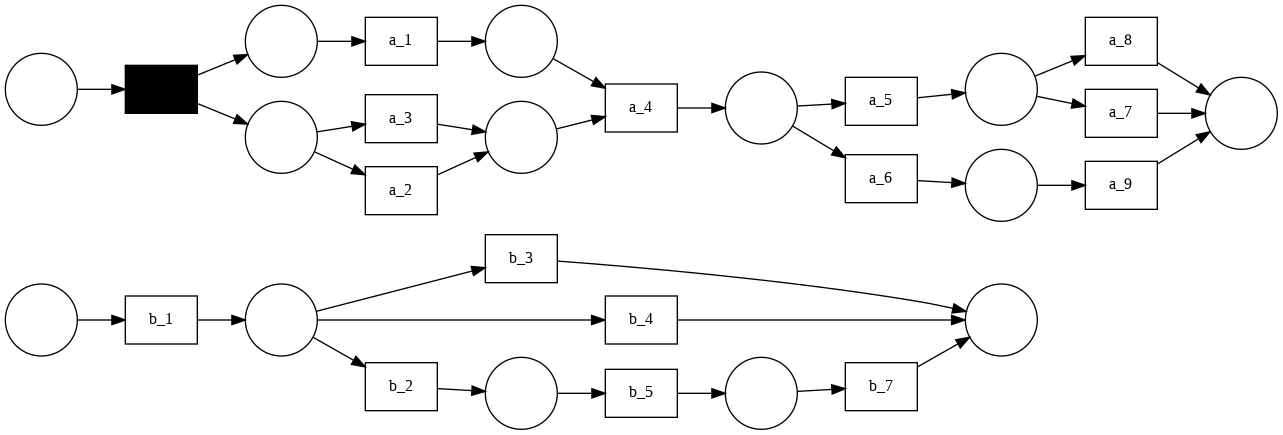

In [ ]:
pm.view_petri_net(petri_net_ind)

## SC ~= 0

In [ ]:
matr = [
    [1, 0, 0, 0],
    [-1, 0, 1, 0],
    [0, 1, -1, 0],
    [0, -1, 0, 1],
    [0, 0, 0, -1],
]
trans_labels = ['a_1', 'a_2', 'b_1', 'b_2']
trans_names = [f't_{i}' for i in range(4)]
places = [f'p_{i}' for i in range(5)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)

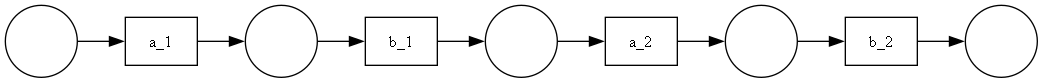

In [ ]:
pm.view_petri_net(petri_net)

In [ ]:
# tm = make_transition_matrix(petri_net)
# print(sc1(tm))
# print(sc2(tm))
# print(sc3(tm))

tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'a_1': {'b_1'}, 'a_2': {'b_2'}, 'b_1': {'a_2'}, 'b_2': set()}
gnc  =  0.0
lnc  =  0.25
blnc =  0.25


## 0 < SC < 1

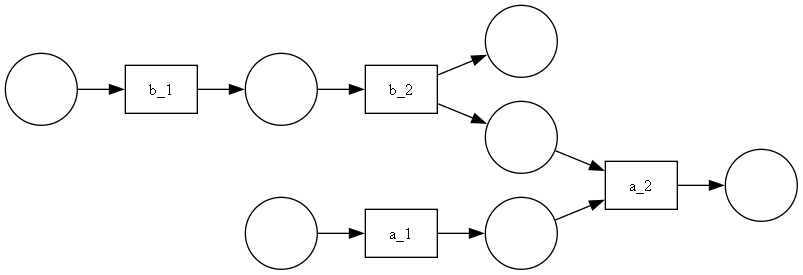

In [ ]:
matr = [
    [0, 0, 1, 0],
    [0, 0, -1, 1],
    [0, 0, 0, -1],
    [1, 0, 0, 0],
    [-1, 1, 0, 0],
    [0, -1, 0, 0],
    [0, 1, 0, -1],
]
trans_labels = ['a_1', 'a_2', 'b_1', 'b_2']
trans_names = [f't_{i}' for i in range(4)]
places = [f'p_{i}' for i in range(7)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)
pm.view_petri_net(petri_net)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'a_1': {'a_2'}, 'b_1': {'b_2'}, 'b_2': {'a_2'}, 'a_2': set()}
gnc  =  0.6666666666666667
lnc  =  0.75
blnc =  0.75


## SC ~= 1

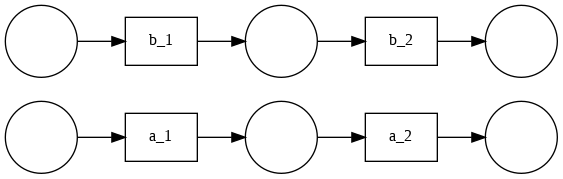

In [ ]:
matr = [
    [0, 0, 1, 0],
    [0, 0, -1, 1],
    [0, 0, 0, -1],
    [1, 0, 0, 0],
    [-1, 1, 0, 0],
    [0, -1, 0, 0],
]

trans_labels = ['a_1', 'a_2', 'b_1', 'b_2']
trans_names = [f't_{i}' for i in range(4)]
places = [f'p_{i}' for i in range(6)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)
pm.view_petri_net(petri_net)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'a_1': {'a_2'}, 'a_2': set(), 'b_1': {'b_2'}, 'b_2': set()}
gnc  =  1.0
lnc  =  1.0
blnc =  1.0


## example for sc_1

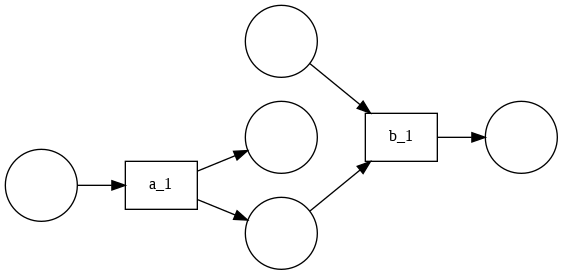

In [ ]:
matr = [
    [0,1],
    [0,-1],
    [1,0],
    [-1,0],
    [-1,1]
]

trans_labels = ['a_1', 'b_1']
trans_names = [f't_{i}' for i in range(2)]
places = [f'p_{i}' for i in range(5)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)
pm.view_petri_net(petri_net)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'a_1': {'b_1'}, 'b_1': set()}
gnc  =  0.0
lnc  =  0.5
blnc =  0.5


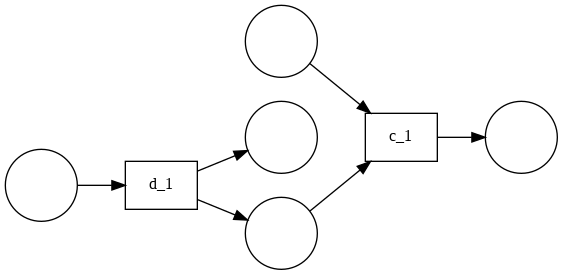

In [ ]:
matr = [
    [0,1],
    [0,-1],
    [1,0],
    [-1,0],
    [1,-1]
]

trans_labels = ['c_1', 'd_1']
trans_names = [f't_{i}' for i in range(2)]
places = [f'p_{i}' for i in range(5)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)
pm.view_petri_net(petri_net)

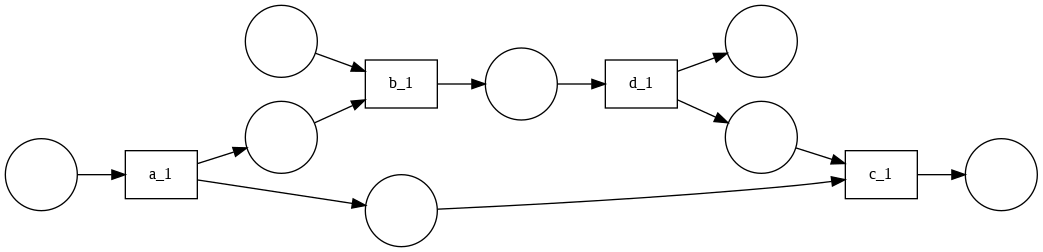

In [ ]:
matr = [
    [0,1, 0, 0],
    [0,-1, 0, 1],
    [1,0, 0, 0],
    [-1,0, 1, 0],
    [-1,1, 0, 0],
    # [0, 0, 0,1],
    [0, 0, 0,-1],
    # [0, 0, 1,0],
    [0, 0, -1,0],
    [0, 0, 1,-1]
]

trans_labels = ['a_1', 'b_1', 'c_1', 'd_1']
trans_names = [f't_{i}' for i in range(4)]
places = [f'p_{i}' for i in range(8)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)
pm.view_petri_net(petri_net)

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(tm)
print('gnc  = ', gnc(tm))
print('lnc  = ', lnc(tm))
print('blnc = ', blnc(tm))

{'a_1': {'c_1', 'b_1'}, 'c_1': set(), 'b_1': {'d_1'}, 'd_1': {'c_1'}}
gnc  =  0.0
lnc  =  0.25
blnc =  0.25


## Random generation

In [ ]:
matr = [
#   a agent
    [1, 0, -1, 0, 0, 0],
    [-1, 0, 1, 0, 0, 0],
    [1, -1, 0, 0, 0, 0],
    [-1, 1, 0, 0, 0, 0],
    [0, 1, -1, 0, 0, 0],
    [0, -1, 1, 0, 0, 0],
#   b agent
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, -1, 1, 0],
    [0, 0, 0, 0, -1, 1],
    [0, 0, 0, 0, 0, -1],
#   connections
    [-1, 0, 0, 1, 0, 0],
    [0, -1, 0, 0, 1, 0],
    [0, 0, -1, 0, 0, 1],
]
trans_labels  = ['a_1', None, None, 'b_1', 'b_2', 'b_3']
trans_names = [f't_{i}' for i in range(6)]
places = [f'p_{i}' for i in range(13)]
petri_net = make_petri_net(matr, trans_labels, trans_names, places)
pm.view_petri_net(petri_net)

In [ ]:
import numpy as np

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
res

array([[ 0,  1,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  1, -1,  0, -1,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  1,  1,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, -1,  0,  1,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, -1, -1, -1, -1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  1, -1,  1,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  1,  1,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  1,  0, -1,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0]])

0.18657747335273522

In [ ]:
res

array([[ 1,  1, -1,  0,  0,  0,  0,  0,  0],
       [ 1, -1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0, -1],
       [ 0,  0,  0,  0,  0,  0,  1,  1, -1],
       [ 1,  0,  0,  0,  0,  0, -1, -1,  0],
       [ 0,  0,  0,  1,  1,  0,  1, -1,  0]])

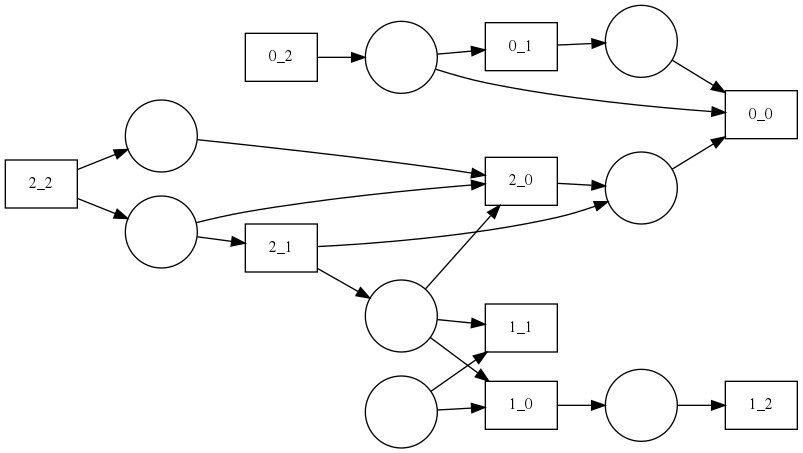

sc_1 =  0.6363636363636364
sc_2 =  0.7777777777777778
sc_3 =  0.8055555555555556


In [ ]:
# pm.view_petri_net(petri_net_1)
# tm2 = make_transition_matrix_v2(petri_net_1)
# print('sc_1 = ', sc1(tm2))
# print('sc_2 = ', sc2(tm2))
# print('sc_3 = ', sc3(tm2))

pm.view_petri_net(petri_net_2)
tm2 = make_transition_matrix_v2(petri_net_2)
print('sc_1 = ', sc1(tm2))
print('sc_2 = ', sc2(tm2))
print('sc_3 = ', sc3(tm2))


In [ ]:
# tm1 = make_transition_matrix(petri_net)
# print(sc1(tm1))
# print(sc2(tm1))
# print(sc3(tm1))

tm2 = make_transition_matrix_v2(petri_net_1)
print('sc_1 = ', sc1(tm2))
print('sc_2 = ', sc2(tm2))
print('sc_3 = ', sc3(tm2))

sc_1 =  0.5
sc_2 =  0.6153846153846154
sc_3 =  0.7626373626373626


In [ ]:
tm2

{'2_1': {'2_2'},
 '0_0': {'0_1', '0_2'},
 '0_3': {'0_0', '0_1', '0_2'},
 '0_1': {'0_2', '1_0', '1_2', '2_2'},
 '1_0': {'0_0', '0_1', '0_3', '1_1', '1_2', '1_3', '2_0', '2_1', '2_2', '2_3'},
 '0_2': {'0_0', '0_1', '0_3', '1_3', '2_0', '2_1', '2_2', '2_3'},
 '1_1': {'0_0',
  '0_1',
  '0_2',
  '0_3',
  '1_0',
  '1_2',
  '1_3',
  '2_0',
  '2_1',
  '2_2',
  '2_3'},
 '1_2': {'0_1', '1_3', '2_0', '2_1'},
 '1_3': {'0_0', '0_3', '2_2', '2_3'},
 '1_4': {'0_1', '1_1', '1_3', '2_0', '2_1'},
 '2_0': {'2_3'},
 '2_2': set(),
 '2_3': {'0_2', '1_0', '1_2', '2_2'}}

In [ ]:
for i, j in zip(sorted(list(tm1.items()), key=lambda x: x[0]), sorted(list(tm2.items()), key=lambda x: x[0])):
    print(i, j)

('0_0', {'1_4'}) ('0_0', {'1_4'})
('0_1', {'0_4', '0_0', '0_3'}) ('0_1', {'0_4', '0_0', '0_3'})
('0_2', {'0_4', '0_0', '0_3'}) ('0_2', {'0_4', '0_0', '0_3'})
('0_3', {'0_1'}) ('0_3', {'0_1'})
('0_4', {'0_3', '0_1', '1_5'}) ('0_4', {'0_3', '0_1', '1_5'})
('1_0', {'1_4'}) ('1_0', {'1_4'})
('1_1', {'1_2', '1_3', '1_5'}) ('1_1', {'1_2', '1_3', '1_5'})
('1_2', {'1_3', '1_0'}) ('1_2', {'1_3', '1_0'})
('1_3', {'1_2', '1_0', '1_4', '1_5'}) ('1_3', {'1_2', '1_0', '1_4', '1_5'})
('1_5', {'1_2', '1_3', '1_0'}) ('1_4', set())


[('0_0', {'1_4'}),
 ('0_1', {'0_0', '0_3', '0_4'}),
 ('0_2', {'0_0', '0_3', '0_4'}),
 ('0_3', {'0_1'}),
 ('0_4', {'0_1', '0_3', '1_5'}),
 ('1_0', {'1_4'}),
 ('1_1', {'1_2', '1_3', '1_5'}),
 ('1_2', {'1_0', '1_3'}),
 ('1_3', {'1_0', '1_2', '1_4', '1_5'}),
 ('1_5', {'1_0', '1_2', '1_3'})]

In [ ]:
f'{agent_num}_{i}'

'1_5'

In [ ]:
make_transition_matrix_v2(petri_net)

{'a_1': {'b_1', 'b_2', 'b_3'}, 'b_1': {'b_2'}, 'b_2': {'b_3'}, 'b_3': set()}

In [ ]:
tm = make_transition_matrix_v2(petri_net)
print(sc1(tm))
print(sc2(tm))
print(sc3(tm))

0.4
0.75


ZeroDivisionError: division by zero

## example for sc_2

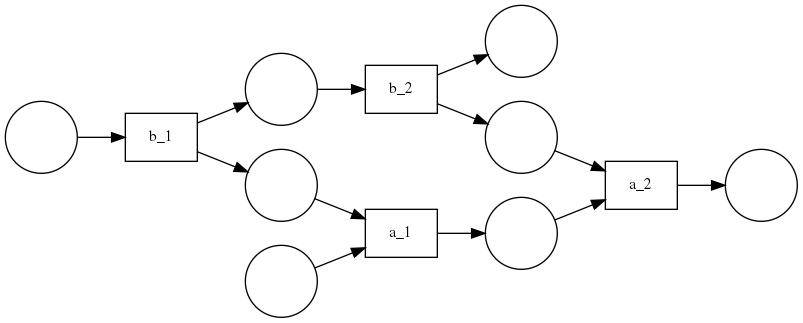

In [ ]:
matr = [
    [0, 0, 1, 0],
    [0, 0, -1, 1],
    [0, 0, 0, -1],
    [1, 0, 0, 0],
    [-1, 1, 0, 0],
    [0, -1, 0, 0],
    [0, 1, 0, -1],
    [1, 0, -1, 0],
]
trans  = ['a_1', 'a_2', 'b_1', 'b_2']
places = [f'p_{i}' for i in range(8)]
petri_net = make_petri_net(matr, trans, places)
pm.view_petri_net(petri_net)

In [ ]:
tm = make_transition_matrix(petri_net)
print(sc1(tm))
print(sc2(tm))
print(sc3(tm))

0.5
0.0
0.5


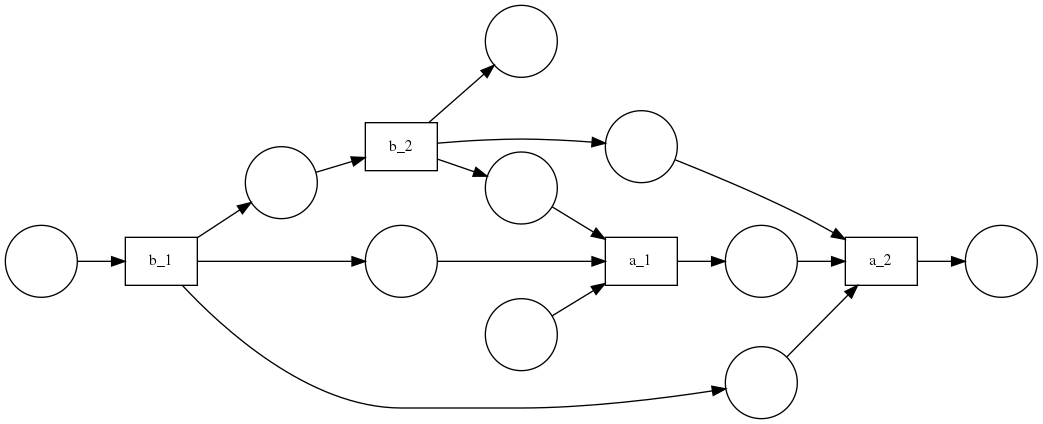

0.33333333333333337
0.0
0.33333333333333337


In [ ]:
matr = [
    [0, 0, 1, 0],
    [0, 0, -1, 1],
    [0, 0, 0, -1],
    [1, 0, 0, 0],
    [-1, 1, 0, 0],
    [0, -1, 0, 0],
    [0, 1, 0, -1],
    [1, 0, -1, 0],
    [1, 0, 0, -1],
    [0, 1, -1, 0],
]
trans  = ['a_1', 'a_2', 'b_1', 'b_2']
places = [f'p_{i}' for i in range(10)]
petri_net = make_petri_net(matr, trans, places)
pm.view_petri_net(petri_net)

tm = make_transition_matrix(petri_net)
print(sc1(tm))
print(sc2(tm))
print(sc3(tm))

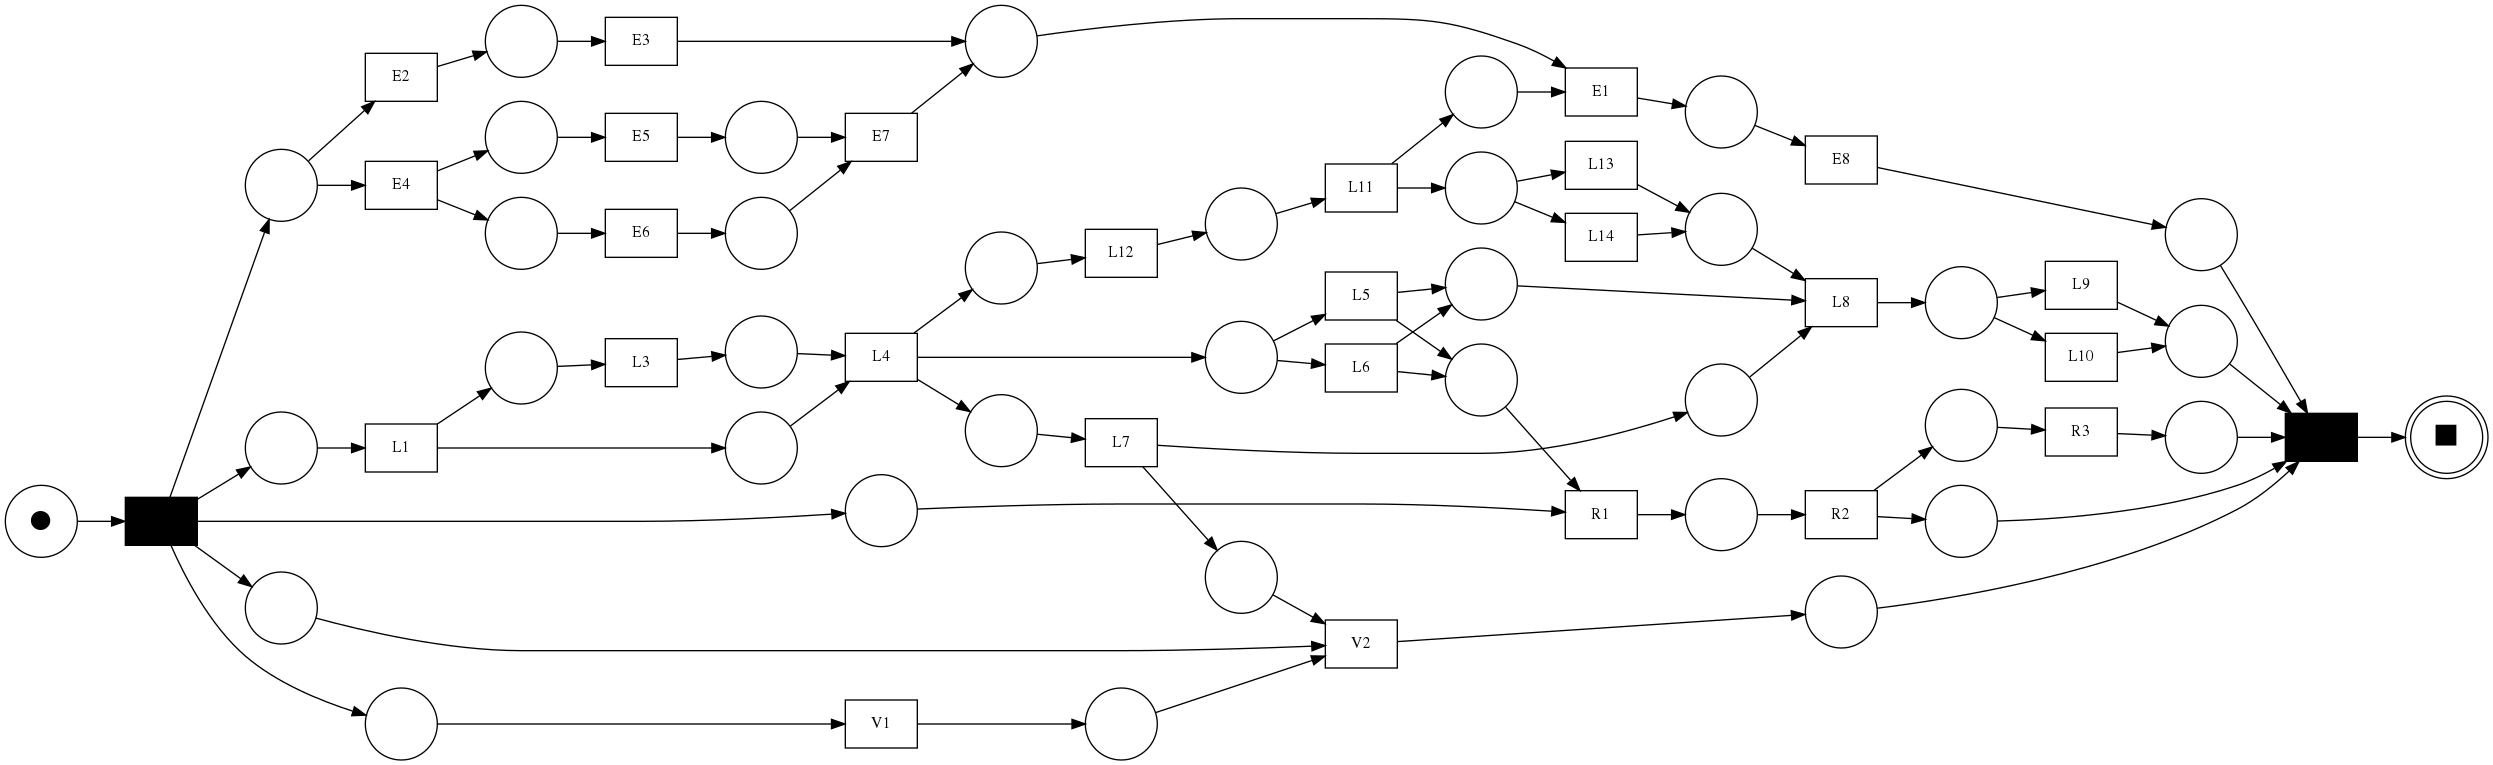

In [ ]:
# def foo(x):
#     return int(str(x).split(',')[0][2:])

# pn, im, fm = pm.read_pnml("Broadcasting(3R).xml", auto_guess_final_marking=True)
# transitions = sorted(list(pn.transitions), key=foo)
# transitions[5].label = 'L1'
# transitions[12].label = 'L3'
# transitions[0].label = 'L4'
# transitions[6].label = 'L5'
# transitions[1].label = 'L6'
# transitions[2].label = 'L7'
# transitions[13].label = 'L8'
# transitions[9].label = 'L9'
# transitions[8].label = 'L10'
# transitions[3].label = 'R1'
# transitions[10].label = 'R2'
# transitions[11].label = 'R3'
# transitions[7].label = 'V1'
# transitions[4].label = 'V2'
# transitions[14].label = None
# transitions[15].label = None

# for i in range(16, 20):
#     transitions[i].label = f'L{i - 5}'
# for i in range(20, 28):
#     transitions[i].label = f'E{i - 19}'

# places = sorted(list(pn.places), key=lambda x: int(str(x)[1:]))
# im = pm.objects.petri_net.obj.Marking({places[21]:1})
# pm.view_petri_net(pn, im, fm)

In [ ]:
transition_matrix = {}
for p in pn.places:
    for in_arc in p.in_arcs:
        for out_arc in p.out_arcs:
            if in_arc.source.label is not None and out_arc.target.label is not None:
                transition_matrix[in_arc.source.label] = transition_matrix.get(
                    in_arc.source.label, set()
                ).union(set([out_arc.target.label]))

                transition_matrix[out_arc.target.label] = transition_matrix.get(
                    out_arc.target.label, set()
                ).union(set([in_arc.source.label]))

In [ ]:
transition_matrix

{'E4': {'E5', 'E6'},
 'E6': {'E4', 'E7'},
 'E7': {'E1', 'E5', 'E6'},
 'R1': {'L5', 'L6', 'R2'},
 'R2': {'R1', 'R3'},
 'L4': {'L1', 'L12', 'L3', 'L5', 'L6', 'L7'},
 'L12': {'L11', 'L4'},
 'L1': {'L3', 'L4'},
 'L6': {'L4', 'L8', 'R1'},
 'L5': {'L4', 'L8', 'R1'},
 'V1': {'V2'},
 'V2': {'L7', 'V1'},
 'L3': {'L1', 'L4'},
 'L11': {'E1', 'L12', 'L13', 'L14'},
 'L13': {'L11', 'L8'},
 'L14': {'L11', 'L8'},
 'L8': {'L10', 'L13', 'L14', 'L5', 'L6', 'L7', 'L9'},
 'E5': {'E4', 'E7'},
 'E1': {'E3', 'E7', 'E8', 'L11'},
 'E8': {'E1'},
 'L7': {'L4', 'L8', 'V2'},
 'R3': {'R2'},
 'E2': {'E3'},
 'E3': {'E1', 'E2'},
 'L10': {'L8'},
 'L9': {'L8'}}

In [ ]:
def sc1(tm):
    n_d = 0
    n_a = 0
    for k, v in tm.items():
        n_a += len(v)
        n_d += len(list(filter(lambda x: x[0] != k[0], v)))
    return 1 - n_d / n_a

def sc2(tm):
    numer = 0
    denom = len(tm)
    for k, v in tm.items():
        if len(list(filter(lambda x: x[0] != k[0], v))) == 0:
            numer += 1
    return numer / denom

def sc3(tm):
    res = 0
    for k, v in tm.items():
        n_a = len(v)
        n_d = len(list(filter(lambda x: x[0] != k[0], v)))
        res += n_d / n_a
    return 1 - res / len(tm)


In [ ]:
print(sc1(transition_matrix))
print(sc2(transition_matrix))
print(sc3(transition_matrix))

0.875
0.7307692307692307
0.8974358974358975
